# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 1: Clustering & Reducción de Dimensionalidad**

### **Nombre:** Luis Miranda D

### Estudiante

El objetivo de esta tarea es utilizar distintos algoritmos de clustering y analizar su desempeño. Se utilizará la base de datos Mice Protein Expression Data Set, que es una base de datos tomadas del UC Irvine Machine Learning Repository. Contiene niveles de expresión de 77 proteínas medidas en fracciones nucleares de células en la corteza cerebral. Hay 38 ratones de control y 34 ratones trisómicos (síndrome de Down). Dado que algunos ratones fueron estimulados para aprender y/o inyectados con memantina, hay 8 grupos en total. 

Se pide utilizar tres algoritmos de clustering en este trabajo: K-Means, DBSCAN y Clustering aglomerativo.

## En los Pasos 0.1 y 0.2, solo debe ejecutar las celdas respectivas

### Paso 0.1: Importación de librerías

In [38]:

import pandas as pd
import numpy as np

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import urllib.request
import os
import warnings
import matplotlib.pyplot as plt

# Para evitar problemas de versión con xlrd
!pip install --upgrade xlrd

# Ocultar el FutureWarning de k-means
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Paso 0.2: Definición de funciones auxiliares

In [39]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = kmeans.fit(data)
    fit_time = time() - t0
    results = [name, estimator.n_clusters, fit_time, estimator.inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator.labels_,
            metric="euclidean",
            #sample_size=300, # No se usa, para que el calculo sea parejo respecto a bench_clustering_2
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.0f}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [40]:
def bench_clustering2(estim, name, data, labels, use_outliers= False):
    """Benchmark to evaluate the DBSCAN and AgglomerativeClustering initialization methods.

    Parameters
    ----------
    estim : DBSCAN or AGC instance
        A :class:`~sklearn.cluster.DBSCAN` or  `~sklearn.cluster.AgglomerativeClustering` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = estim.fit(data)
    fit_time = time() - t0

    
    e_labels = estimator.labels_

    # Ni DBSCAN ni Agglomerative poseen la variable inertia_., DBSCAN no posee la variable n_clusters
    try:
      n_clusters = estimator.n_clusters
      results = [name, n_clusters, fit_time, -1]
    except: 
      # Es dbscan (falla en n_clusters)

      if use_outliers: # Se usan los outliers
        n_clusters = len(set(e_labels))
        results = [name, n_clusters, fit_time, -1]

      else: # No se usan los outliers
        n_clusters = len(set(e_labels))- (1 if -1 in e_labels else 0)
        results = [name, n_clusters, fit_time, -1]

        # Sólo se usan los datos que no contemplan outliers
        indexs = np.argwhere(e_labels!=-1)
        if len(indexs)>1:
          indexs = np.concatenate(indexs)
          data = data[indexs,]
          labels = labels[indexs,]
          e_labels = e_labels[indexs,]


    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    # Si hay más de un cluster
    if n_clusters>1:
      results += [m(labels, e_labels) for m in clustering_metrics]

      # The silhouette score requires the full dataset
      results += [
          metrics.silhouette_score(
              data,
              e_labels,
              metric="euclidean",
              #sample_size= None, # No se usa ya que puede dar errores si la muestra extraída solamente posee un solo label
          )
      ]
    else:
      results += [-1 for i in range(len(clustering_metrics)+1)] 

    # Show the results
    formatter_result = (
        "{:9s}\t{:.0f}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## De aquí en adelante empezará su implementación, la cuál será guiada

# Parte 1

Implemente un código que lea la base de datos "data_cortex_nuclear.csv" proporcionada en U-Campus. Se recomienda usar la biblioteca Pandas.

Se debe eliminar la columna BCL2_N, dado que contiene muchos valores NaN. Asimismo, las filas que contienen valores NaN deben ser eliminadas. Finalmente, para esta tarea, se recomienda no usar scale( ) sobre los datos.

In [41]:
############################################
# Importamos dos librerias mas para poder descargar los datos directamente y descargarlos en nuestro directorio de trabajo.

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls"
filename = "Data_Cortex_Nuclear.xls" 
urllib.request.urlretrieve(url, filename)


# Leyendo los datos
df = pd.read_excel(filename)
df

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s
1076,J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s
1077,J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s
1078,J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,...,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031,Ts65Dn,Saline,S/C,t-SC-s


## Parte 1.1: Pre Procesamiento de la base de datos.


---


*   Se procede a eliminar la columna "BCL2_N" por tener muchos datos nulos.
*   Se procede a hacer una limpieza de todas las filas con datos nulos.






In [42]:
# Pre Procesamiento
print("##### Antes del PreProcesamiento #####")
print("Cantidad de Instancias:", df.shape[0],"\n","Cantidad de Columnas:", df.shape[1])
print("Los Nombres de las Columnas son:",df.columns)

##### Antes del PreProcesamiento #####
Cantidad de Instancias: 1080 
 Cantidad de Columnas: 82
Los Nombres de las Columnas son: Index(['MouseID', 'DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N',
       'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N',
       'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N',
       'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N',
       'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N',
       'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N',
       'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N',
       'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N',
       'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N',
       'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N',
       'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N',
       'pS6_N', 'pCFOS_N', 'SYP_N', 'H3

In [43]:
# Columna con mayor cantidad de nulos:
print("Columna con Mayor cantidad de nulos:", df.isnull().sum().idxmax(), "\nCantidad: ",df['BCL2_N'].isnull().sum())

Columna con Mayor cantidad de nulos: BCL2_N 
Cantidad:  285


In [44]:
# Se procede a eliminar la columna con mayor cantidad de nulos y todas las entradas de datos nulos en el dataframe
df = df.drop("BCL2_N",axis=1)
df.dropna(inplace=True)

print("##### Despues del PreProcesamiento #####")
print("Cantidad de Instancias:", df.shape[0],"\n","Cantidad de Columnas:", df.shape[1])
print("Los Nombres de las Columnas son:",df.columns)
print("Cantidad Maxima de Nulos despues de pre procesamiento: ",df.isnull().sum().max())

##### Despues del PreProcesamiento #####
Cantidad de Instancias: 612 
 Cantidad de Columnas: 81
Los Nombres de las Columnas son: Index(['MouseID', 'DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N',
       'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N',
       'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N',
       'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N',
       'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N',
       'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N',
       'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N',
       'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N',
       'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N',
       'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N',
       'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'pS6_N',
       'pCFOS_N', 'SYP_N', 'H3AcK18_N',

In [45]:
# Veamos la naturaleza de los datos, en este caso el tipo de dato de cada columna.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 1079
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MouseID          612 non-null    object 
 1   DYRK1A_N         612 non-null    float64
 2   ITSN1_N          612 non-null    float64
 3   BDNF_N           612 non-null    float64
 4   NR1_N            612 non-null    float64
 5   NR2A_N           612 non-null    float64
 6   pAKT_N           612 non-null    float64
 7   pBRAF_N          612 non-null    float64
 8   pCAMKII_N        612 non-null    float64
 9   pCREB_N          612 non-null    float64
 10  pELK_N           612 non-null    float64
 11  pERK_N           612 non-null    float64
 12  pJNK_N           612 non-null    float64
 13  PKCA_N           612 non-null    float64
 14  pMEK_N           612 non-null    float64
 15  pNR1_N           612 non-null    float64
 16  pNR2A_N          612 non-null    float64
 17  pNR2B_N        

Se procede a borrar los ID de los datos

In [46]:
df.drop('MouseID',axis=1,inplace=True)

Ahora convertiremos los valores object a numericos, no los borraremos para no perder informacion dentro de la BBDD.



In [47]:
from sklearn.preprocessing import LabelEncoder
# Creamos una instancia de la clase LabelEncoder y ajustamos a los valores únicos en la columna
le1 = LabelEncoder().fit(df['Genotype'].unique())
le2 = LabelEncoder().fit(df['Treatment'].unique())
le3 = LabelEncoder().fit(df['Behavior'].unique())
le4 = LabelEncoder().fit(df['class'].unique())

# Transformamos los valores de la columna a valores numéricos
df['Genotype'] = le1.transform(df['Genotype'])
df['Treatment'] = le2.transform(df['Treatment'])
df['Behavior'] = le3.transform(df['Behavior'])
df['class'] = le4.transform(df['class'])

# Imprimimos el dataframe resultante
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 1079
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DYRK1A_N         612 non-null    float64
 1   ITSN1_N          612 non-null    float64
 2   BDNF_N           612 non-null    float64
 3   NR1_N            612 non-null    float64
 4   NR2A_N           612 non-null    float64
 5   pAKT_N           612 non-null    float64
 6   pBRAF_N          612 non-null    float64
 7   pCAMKII_N        612 non-null    float64
 8   pCREB_N          612 non-null    float64
 9   pELK_N           612 non-null    float64
 10  pERK_N           612 non-null    float64
 11  pJNK_N           612 non-null    float64
 12  PKCA_N           612 non-null    float64
 13  pMEK_N           612 non-null    float64
 14  pNR1_N           612 non-null    float64
 15  pNR2A_N          612 non-null    float64
 16  pNR2B_N          612 non-null    float64
 17  pPKCAB_N       

## Parte 1.2 Analisis Exploratorio de Datos.

### Parte 1.2.1 Distribucion de los atributos

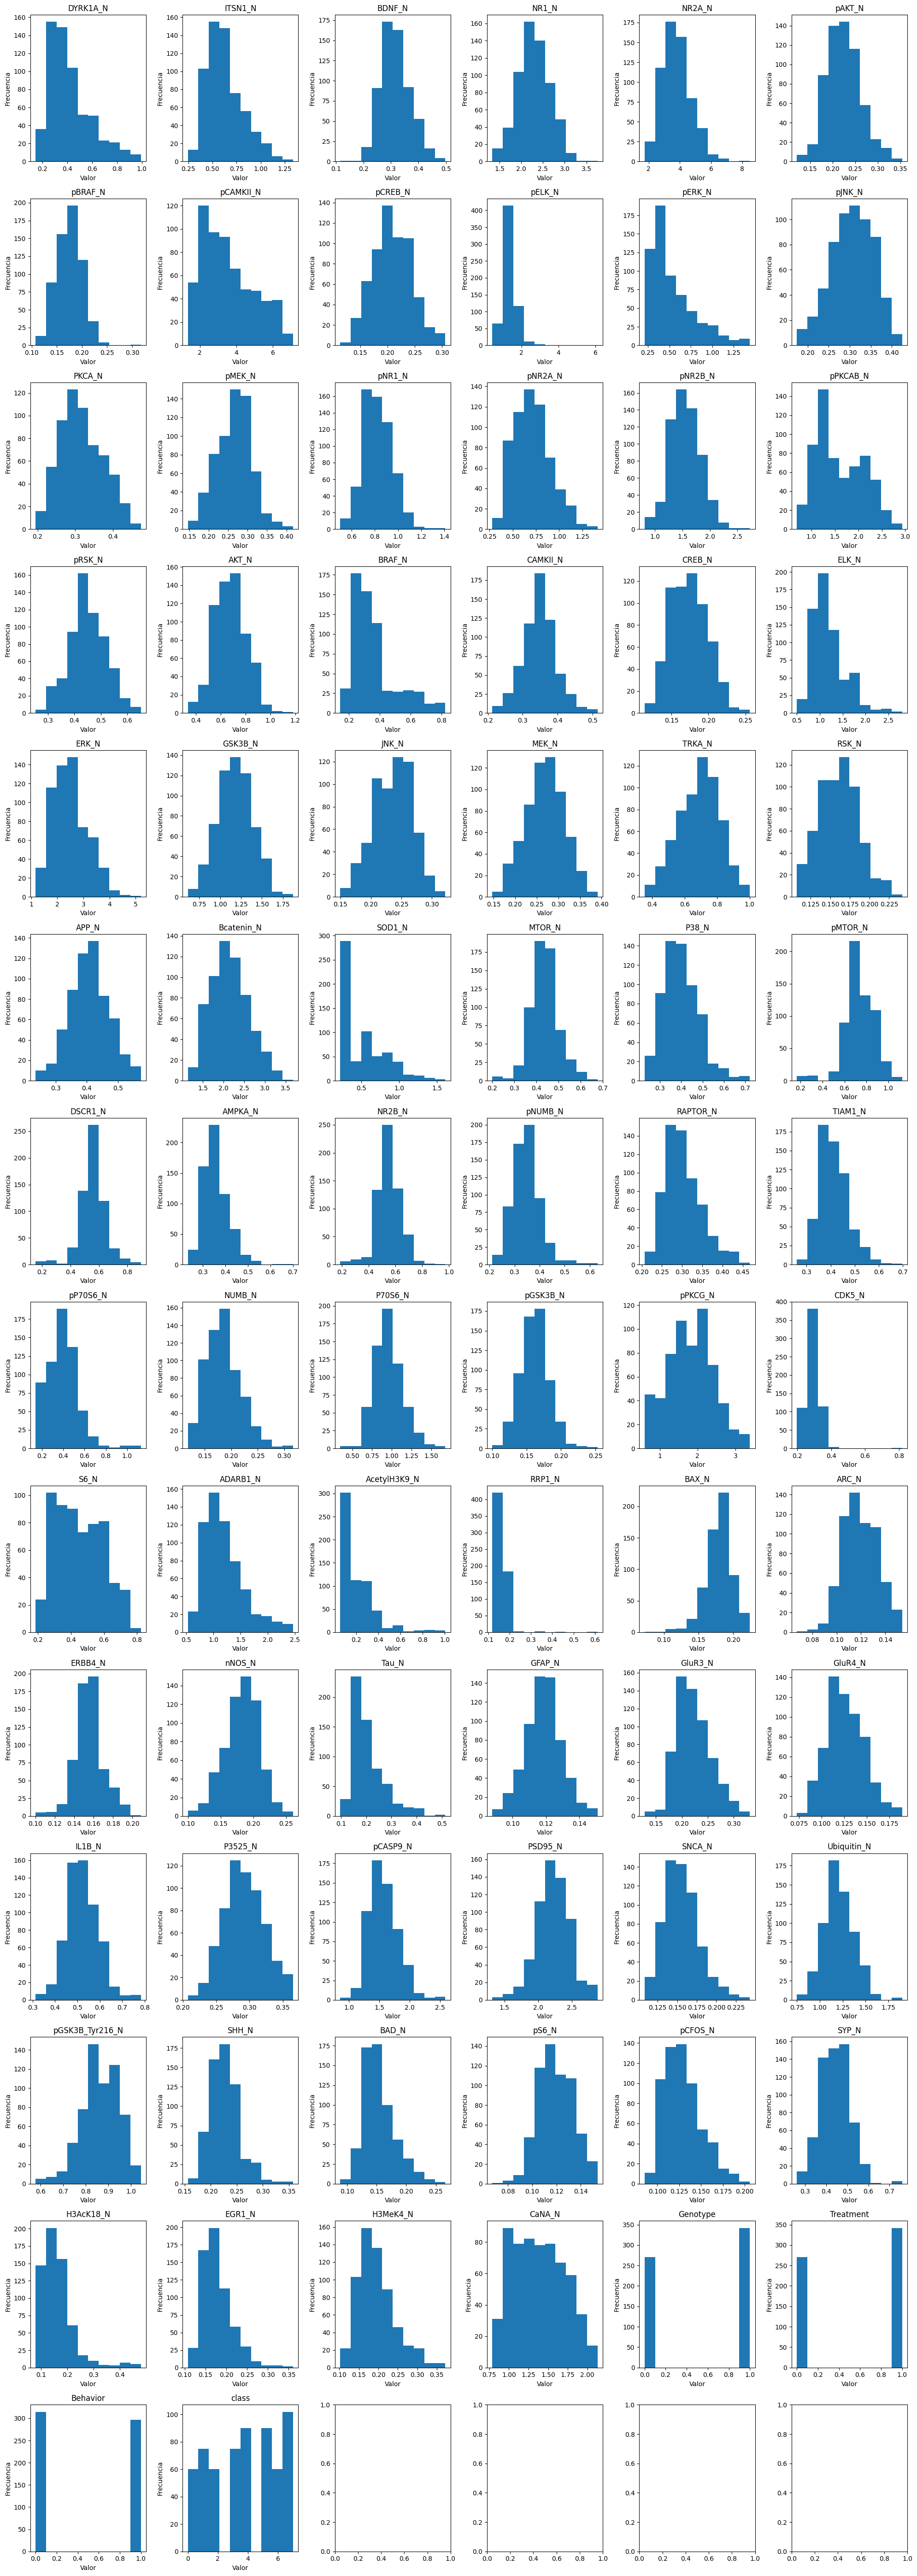

In [48]:
# Veamos las distribuciones de los datos.
num_cols = df.shape[1]
num_rows = int(np.ceil(num_cols / 6))
fig, axs = plt.subplots(nrows=num_rows, ncols=6, figsize=(20, 4*num_rows))

# Recorrer cada columna del array y graficar su histograma en un subplot diferente
for i, ax in enumerate(axs.flatten()):
    if i < num_cols:
        ax.hist(df.iloc[:, i])
        ax.set_title(df.columns[i])
        ax.set_xlabel("Valor")
        ax.set_ylabel("Frecuencia")

# Ajustar los subplots para que se vean bien y mostrar la figura
plt.tight_layout()
plt.show()

### Comentarios:

Podemos ver claramente que las principales distribuciones de los datos, corresponden a las siguientes categorias:


*   Normal.
*   Asimetrica Positiva.
*   Asimetrica Negativa.
*   Bimodal

En general se observan distribuciones de datos simetricas, con algunas columnas donde ocurren sesgos.



### Parte 1.2.2 Gráficos de Caja de los atributos.

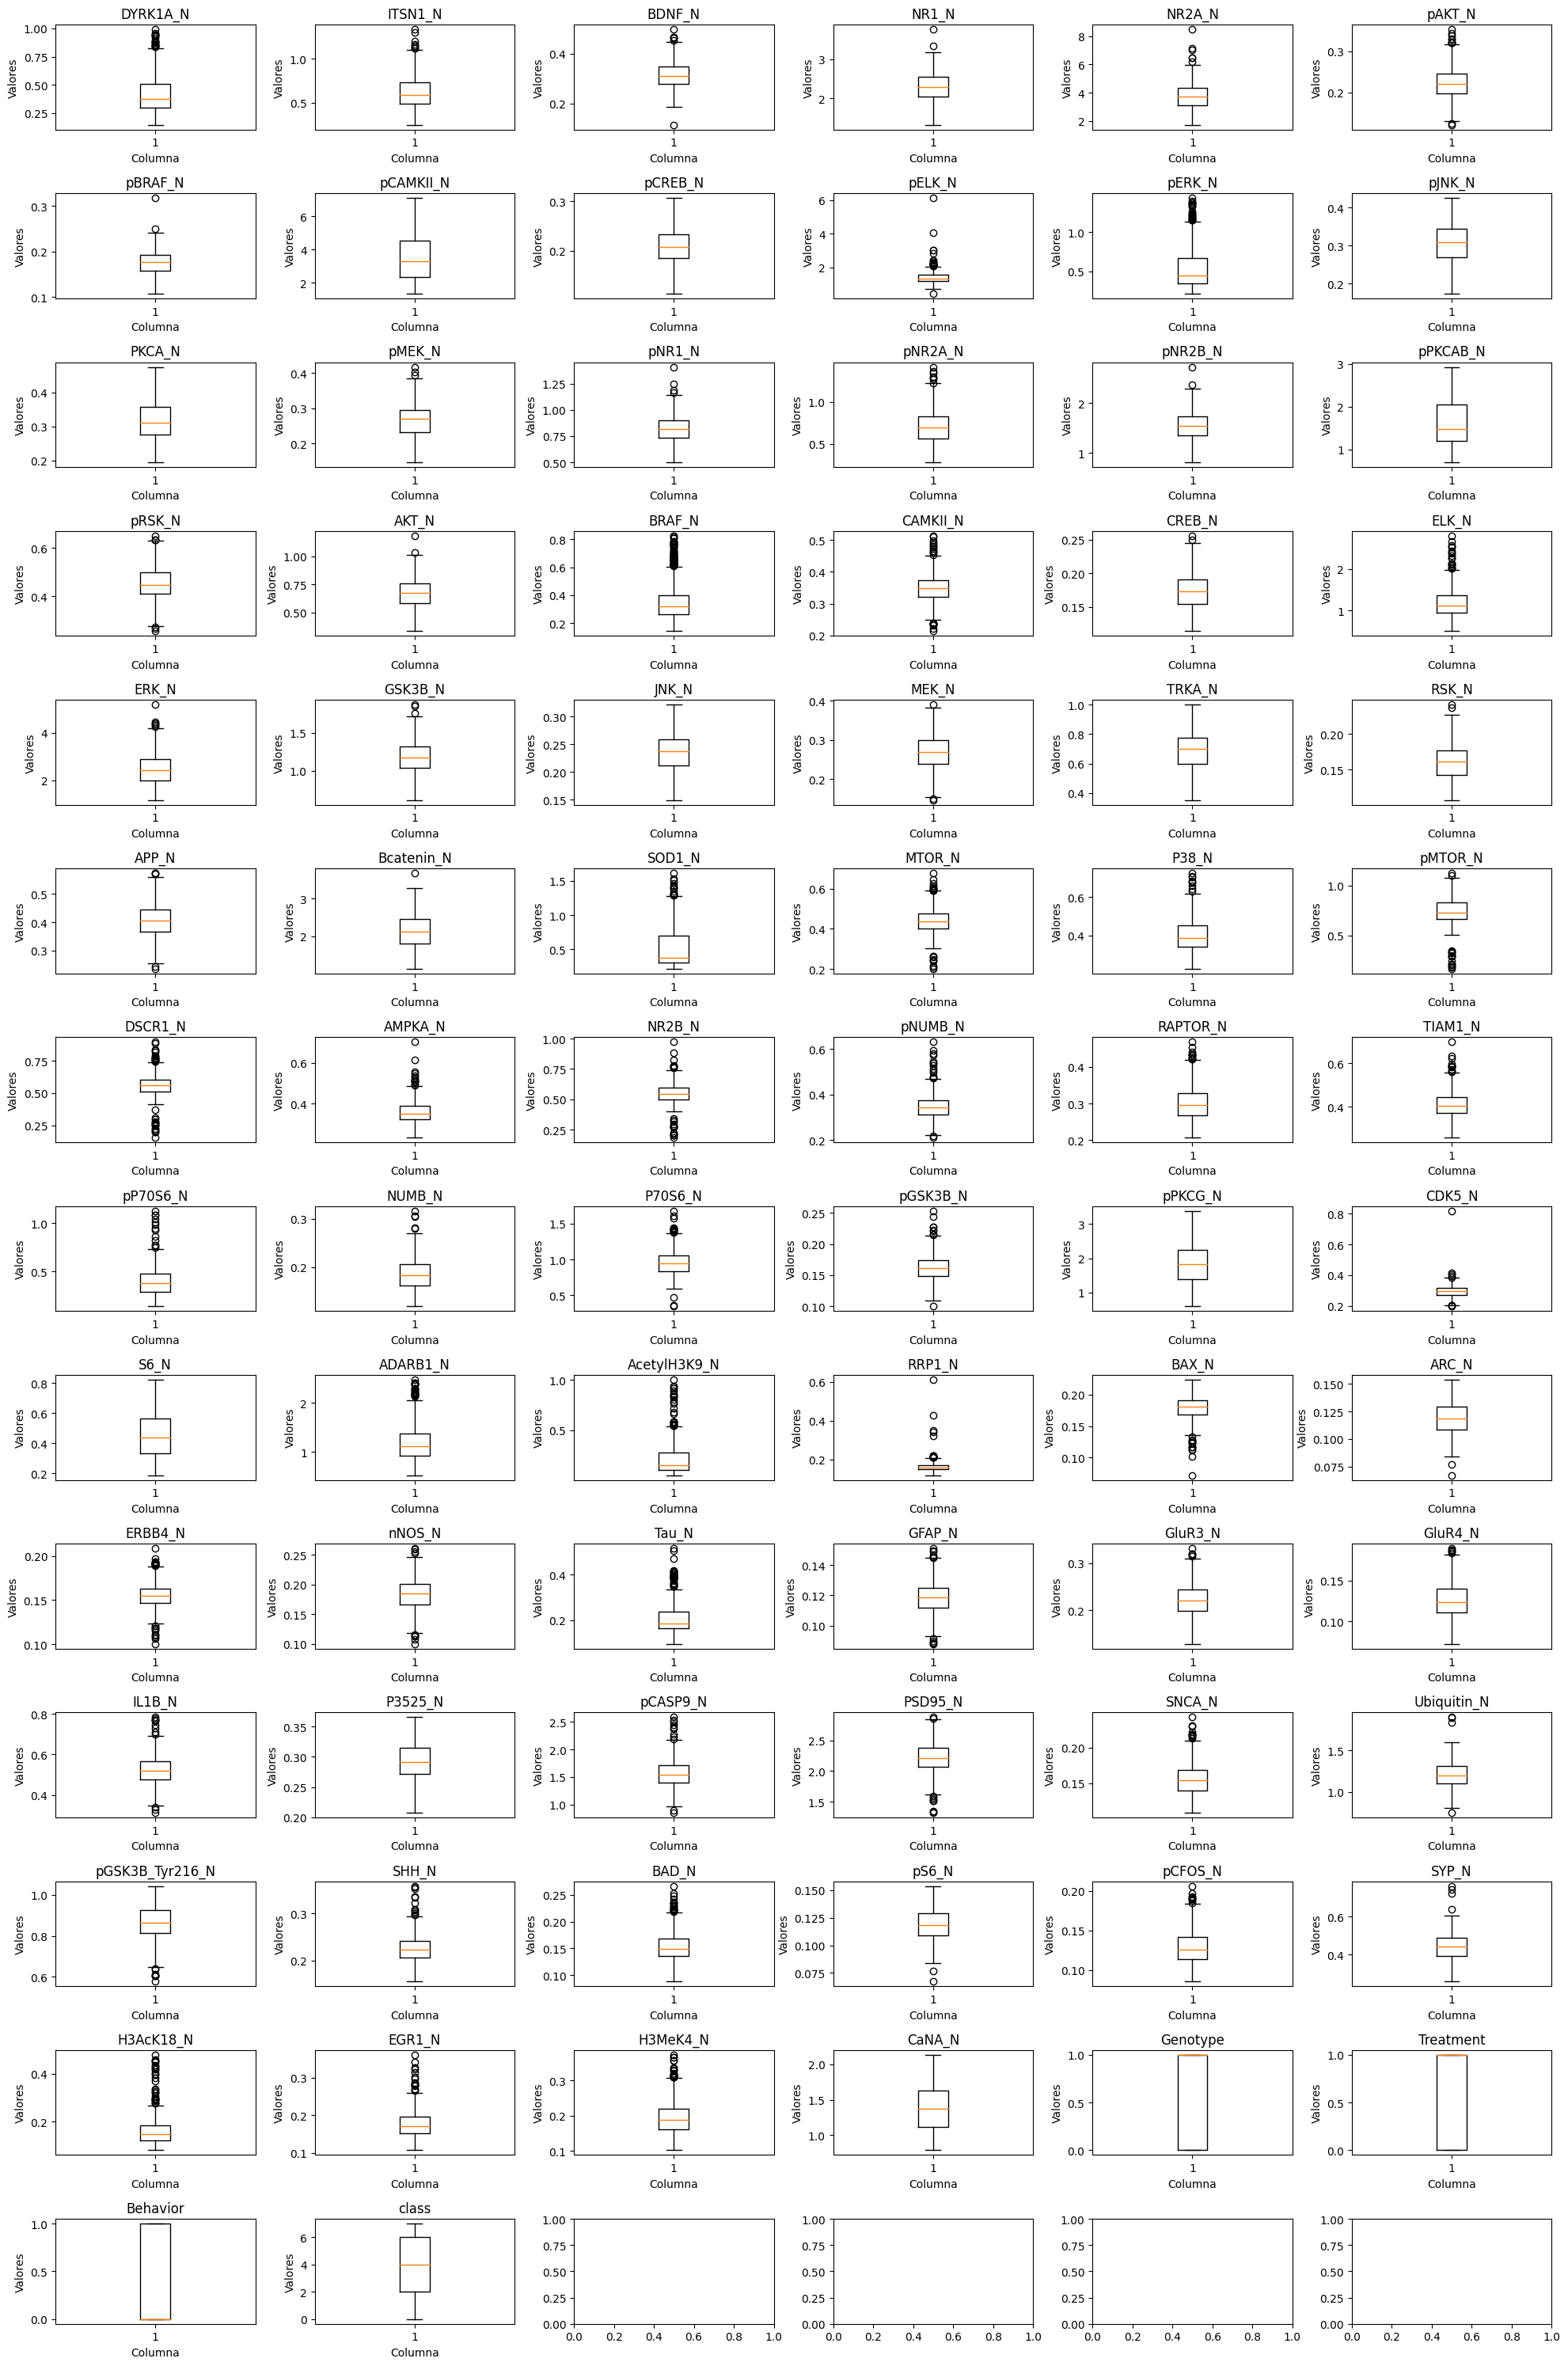

In [49]:
rows = 14
cols = 6

# crear la figura y los subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 30))

# generar un gráfico de caja para cada columna
outlier_cols = []
outlier_dict = {}
for i, col in enumerate(df.columns):
    ax = axs[i // cols, i % cols]
    ax.boxplot(df[col])
    ax.set_title(col)
    ax.set_xlabel("Columna")
    ax.set_ylabel("Valores")

    # detectar outliers en la columna actual
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > 0:
        outlier_cols.append(col)
        outlier_dict[col] = len(outliers)

plt.tight_layout()
plt.show()


In [50]:
print("Cantidad de columnas con outliers:", len(outlier_cols))
print("Columnas con outliers:")
for col, num_outliers in outlier_dict.items():
    print(col + ": " + str(num_outliers))

Cantidad de columnas con outliers: 65
Columnas con outliers:
DYRK1A_N: 20
ITSN1_N: 8
BDNF_N: 6
NR1_N: 2
NR2A_N: 6
pAKT_N: 11
pBRAF_N: 2
pELK_N: 21
pERK_N: 22
pMEK_N: 3
pNR1_N: 4
pNR2A_N: 7
pNR2B_N: 2
pRSK_N: 7
AKT_N: 2
BRAF_N: 59
CAMKII_N: 22
CREB_N: 2
ELK_N: 19
ERK_N: 6
GSK3B_N: 3
MEK_N: 3
RSK_N: 2
APP_N: 5
Bcatenin_N: 1
SOD1_N: 14
MTOR_N: 21
P38_N: 9
pMTOR_N: 17
DSCR1_N: 32
AMPKA_N: 13
NR2B_N: 23
pNUMB_N: 16
RAPTOR_N: 12
TIAM1_N: 12
pP70S6_N: 13
NUMB_N: 5
P70S6_N: 16
pGSK3B_N: 9
CDK5_N: 8
ADARB1_N: 21
AcetylH3K9_N: 25
RRP1_N: 14
BAX_N: 14
ARC_N: 2
ERBB4_N: 25
nNOS_N: 10
Tau_N: 31
GFAP_N: 12
GluR3_N: 5
GluR4_N: 5
IL1B_N: 12
pCASP9_N: 11
PSD95_N: 10
SNCA_N: 11
Ubiquitin_N: 4
pGSK3B_Tyr216_N: 7
SHH_N: 12
BAD_N: 19
pS6_N: 2
pCFOS_N: 9
SYP_N: 4
H3AcK18_N: 31
EGR1_N: 16
H3MeK4_N: 21


### Comentarios:
Existen 65 columnas que tienen valores outliers en la medicion de los datos, esto se puede generar debido a distintas circunstancias como errores de medición, errores en la entrada de datos, eventos raros o simplemente por la variabilidad natural de los datos. Es importante considerar los outliers al analizar los datos, ya que pueden afectar la precisión de las estadísticas y de los modelos. Por lo tanto, es necesario determinar si los outliers son verdaderos valores extremos o simplemente errores de medición, y tomar medidas apropiadas según el caso.


### Parte 1.2.3 Análisis matriz de covarianza.

In [51]:
# Matriz de Covarianza de los datos.
cov_matrix = df.cov()
cov_matrix

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
DYRK1A_N,0.028336,0.029011,0.002965,0.012923,0.040427,-0.001086,-0.000306,-0.027491,0.000832,0.036793,...,-0.001306,-0.001411,-0.003204,-0.002771,-0.003441,0.024747,0.031782,-0.015639,-0.052254,0.006980
ITSN1_N,0.029011,0.034511,0.004738,0.026310,0.068274,-0.000656,-0.000089,-0.012816,0.002222,0.040319,...,-0.001798,0.000911,-0.002689,-0.003641,-0.003904,0.030498,0.041605,-0.010060,-0.051018,0.054325
BDNF_N,0.002965,0.004738,0.002773,0.015829,0.036863,0.000840,0.000636,0.023585,0.001340,0.007991,...,-0.000379,0.002130,-0.000386,-0.000540,-0.000584,0.005438,0.001027,0.001707,-0.002710,0.000396
NR1_N,0.012923,0.026310,0.015829,0.131178,0.298381,0.004881,0.003481,0.183047,0.009315,0.053672,...,-0.002910,0.015401,-0.003566,-0.005014,-0.005242,0.026406,-0.019180,0.015115,0.002988,-0.055628
NR2A_N,0.040427,0.068274,0.036863,0.298381,0.845241,0.008980,0.005580,0.459686,0.017703,0.131290,...,-0.007875,0.030712,-0.014575,-0.014060,-0.018505,0.051865,-0.053386,-0.004403,-0.019399,-0.256747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CaNA_N,0.024747,0.030498,0.005438,0.026406,0.051865,-0.002306,-0.000896,-0.140415,0.001683,0.015002,...,-0.002483,0.007447,-0.003292,-0.005908,-0.004234,0.101489,0.018173,0.019172,-0.115148,-0.138434
Genotype,0.031782,0.041605,0.001027,-0.019180,-0.053386,0.002692,0.000687,0.052350,0.004100,0.016016,...,-0.001327,-0.003131,0.009313,-0.001456,0.004220,0.018173,0.246943,0.001444,-0.006499,0.976220
Treatment,-0.015639,-0.010060,0.001707,0.015115,-0.004403,-0.001889,-0.001659,-0.223180,0.002554,-0.007184,...,0.000068,0.005907,-0.002548,-0.001597,-0.000682,0.019172,0.001444,0.246943,0.018051,0.288823
Behavior,-0.052254,-0.051018,-0.002710,0.002988,-0.019399,0.008351,0.004228,0.299211,0.003924,-0.042179,...,0.002523,0.003705,0.009552,0.008010,0.010201,-0.115148,-0.006499,0.018051,0.250193,0.492442


## Parte 2 & 3

Entrenar los siguientes algoritmos de clustering, con los parámetros especificados:
    
*   K-Means (con inicialización al azar), usando 8 clusters
*   K-Means++, usando 8 clusters
*   DBSCAN con épsilon por defecto
*   DBSCAN con épsilon 0.7
*   DBSCAN con épsilon 0.2
*   DBSCAN con épsilon por defecto, agregando outliers a cluster extra
*   DBSCAN con épsilon 0.7, agregando outliers a cluster extra
*   DBSCAN con épsilon 0.2, agregando outliers a cluster extra
*   Clustering aglomerativo, usando 8 clusters

Para el entrenamiento, use las funciones bench_k_means( ) y bench_clustering2( ), las cuales serán usadas para obtener un benchmark de K-Means, DBSCAN y Clustering Aglomerativo. 

In [52]:
# Primero que todo preparamos los datos 
# cortando el dataframe de la siguiente forma
data = np.array(df.drop('class',axis=1))
labels = np.array(df['class'])

In [53]:
print(90 * "_")
print("init\t\tnum\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans_random = KMeans(n_clusters=8, init='random')
bench_k_means(kmeans_random, "K-Means Random", data, labels)

kmeans_plusplus = KMeans(n_clusters=8, init='k-means++')
bench_k_means(kmeans_plusplus, "K-Means++", data, labels)

dbscan_default = DBSCAN()
bench_clustering2(dbscan_default, "DBSCAN", data, labels)

dbscan_07 = DBSCAN(eps=0.7)
bench_clustering2(dbscan_07, "DBSCAN e0.7", data, labels)

dbscan_02 = DBSCAN(eps=0.2)
bench_clustering2(dbscan_02, "DBSCAN e0.2", data, labels)

dbscan_outliers = DBSCAN()
bench_clustering2(dbscan_outliers, "DBSCAN out", data, labels, use_outliers=True)

dbscan_outliers_07 = DBSCAN(eps=0.7)
bench_clustering2(dbscan_outliers_07, "DBSCAN e0.7 out", data, labels, use_outliers=True)

dbscan_outliers_02 = DBSCAN(eps=0.2)
bench_clustering2(dbscan_outliers_02, "DBSCAN e0.2 out", data, labels, use_outliers=True)

agglo = AgglomerativeClustering(n_clusters=8)
bench_clustering2(agglo,"Agglo 8", data, labels)

print(90 * "_")


__________________________________________________________________________________________
init		num	time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
K-Means Random	8	0.172s	1431	0.387	0.387	0.387	0.219	0.374	0.207
K-Means++	8	0.202s	1416	0.429	0.429	0.429	0.245	0.418	0.218
DBSCAN   	12	0.008s	-1	1.000	0.705	0.827	0.539	0.771	0.717
DBSCAN e0.7	42	0.009s	-1	1.000	0.551	0.711	0.278	0.652	0.434
DBSCAN e0.2	0	0.011s	-1	-1.000	-1.000	-1.000	-1.000	-1.000	-1.000
DBSCAN out	13	0.009s	-1	0.107	0.365	0.165	0.002	0.113	-0.319
DBSCAN e0.7 out	43	0.008s	-1	0.575	0.433	0.494	0.069	0.427	0.031
DBSCAN e0.2 out	1	0.009s	-1	-1.000	-1.000	-1.000	-1.000	-1.000	-1.000
Agglo 8  	8	0.023s	-1	0.518	0.521	0.519	0.310	0.509	0.180
__________________________________________________________________________________________


## Parte 2 & 4

Reduzca la base de datos cargada y pre-procesada a 2 dimensiones, usando PCA

Entrenar los siguientes algoritmos de clustering, con los parámetros especificados:
    
*   K-Means (con inicialización al azar), usando 8 clusters
*   K-Means++, usando 8 clusters
*   DBSCAN con épsilon por defecto
*   DBSCAN con épsilon 0.7
*   DBSCAN con épsilon 0.2
*   DBSCAN con épsilon por defecto, agregando outliers a cluster extra
*   DBSCAN con épsilon 0.7, agregando outliers a cluster extra
*   DBSCAN con épsilon 0.2, agregando outliers a cluster extra
*   Clustering aglomerativo, usando 8 clusters

Para el entrenamiento, use las funciones bench_k_means( ) y bench_clustering2( ), las cuales serán usadas para obtener un benchmark de K-Means, DBSCAN y Clustering Aglomerativo.

## Parte 2.1 Reduccion de Dimensionalidad

In [54]:
# Puede usar los metodos PCA de la libreria sklearn.decomposition y KMeans, DBSCAN, AgglomerativeClustering de la libreria sklearn.cluster
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)

print(reduced_data)

[[ 0.79423173  3.00432971]
 [ 0.43383518  2.69955886]
 [ 0.40948876  2.7065265 ]
 ...
 [-2.58210045 -1.23332484]
 [-2.31603137 -1.09922594]
 [-1.80463956 -0.88651672]]


In [55]:
print(90 * "_")
print("init\t\tnum\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans_random = KMeans(n_clusters=8, init='random')
bench_k_means(kmeans_random, "K-Means Random", reduced_data, labels)

kmeans_plusplus = KMeans(n_clusters=8, init='k-means++')
bench_k_means(kmeans_plusplus, "K-Means++", reduced_data, labels)

dbscan_default = DBSCAN()
bench_clustering2(dbscan_default, "DBSCAN", reduced_data, labels)

dbscan_07 = DBSCAN(eps=0.7)
bench_clustering2(dbscan_07, "DBSCAN e0.7", reduced_data, labels)

dbscan_02 = DBSCAN(eps=0.2)
bench_clustering2(dbscan_02, "DBSCAN e0.2", reduced_data, labels)

dbscan_outliers = DBSCAN()
bench_clustering2(dbscan_outliers, "DBSCAN out", reduced_data, labels, use_outliers=True)

dbscan_outliers_07 = DBSCAN(eps=0.7)
bench_clustering2(dbscan_outliers_07, "DBSCAN e0.7 out", reduced_data, labels, use_outliers=True)

dbscan_outliers_02 = DBSCAN(eps=0.2)
bench_clustering2(dbscan_outliers_02, "DBSCAN e0.2 out", reduced_data, labels, use_outliers=True)

agglo = AgglomerativeClustering(n_clusters=8)
bench_clustering2(agglo,"Agg 8", reduced_data, labels)

print(90 * "_")


__________________________________________________________________________________________
init		num	time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
K-Means Random	8	0.137s	356	0.253	0.253	0.253	0.117	0.238	0.354
K-Means++	8	0.153s	352	0.232	0.236	0.234	0.109	0.218	0.371
DBSCAN   	1	0.007s	-1	-1.000	-1.000	-1.000	-1.000	-1.000	-1.000
DBSCAN e0.7	1	0.007s	-1	-1.000	-1.000	-1.000	-1.000	-1.000	-1.000
DBSCAN e0.2	21	0.005s	-1	0.386	0.288	0.330	0.113	0.265	0.320
DBSCAN out	2	0.008s	-1	0.005	0.093	0.010	0.000	0.004	0.367
DBSCAN e0.7 out	2	0.008s	-1	0.005	0.335	0.010	0.000	0.005	0.498
DBSCAN e0.2 out	22	0.005s	-1	0.252	0.222	0.236	0.044	0.185	-0.088
Agg 8    	8	0.012s	-1	0.247	0.251	0.249	0.117	0.234	0.332
__________________________________________________________________________________________
